<a target="_blank" href="https://colab.research.google.com/github/evaalonsoortiz/ELE8812-demos/blob/main/Demos/Lesson%204/Le%C3%A7on_4_Demo_hom.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# ELE8812 - Traitement fréquentiel

## Démo : Rehaussement par filtrage homomorphique

### Référence : DIP 4e édition, Chapitre 4, « Homomorphic filtering» p.293

Une image peut être décomposée en luminance et réflectance, f(x,y) = i(x,y)r(x,y). Le filtrage homomorphique permet de traiter de façon séparée chaque composante. La première étape consiste à effectuer une transformation logarithmique de l’image, ce qui donne ln f(x,y) = ln i(x,y) + ln r(x,y). Note : si l’image contient des zéros on additionne 1 à l’image avant d’effectuer la transformation pour éviter le cas ln (0), on soustrait ensuite 1 au résultat final. Cette formulation permet d’opérer sur les 2 composantes de façon séparée dans le domaine fréquentiel puisque la transformée de Fourier (TF) d’une somme correspond à la somme des TF (propriété de linéarité). La composante de luminance est généralement caractérisée par des variations spatiales lentes (fréquences faibles de la TF de l’image) tandis que la réflectance est caractérisée par des variations plus abruptes (fréquences élevées de la TF de l’image). Un filtre homomorphique affecte les fréquences faibles et élevées de façon différente. Selon les paramètres de filtrage choisis, il est possible d’atténuer la contribution des fréquences faibles (luminance) et d’amplifier celle des fréquences élevées (réflectance).  Ceci entraîne une compression de la plage dynamique de l’image et une augmentation du contraste. Après avoir appliqué le filtre dans le domaine fréquentiel, une TF inverse est effectuée, suivie d’une transformation exponentielle pour obtenir le résultat final.


Dans ce démo, une image provenant d’un TEP scan sera utilisée. L’image est floue et certains *hot spots* dominent la plage dynamique des valeurs ce qui cause un contraste faible dans les régions à plus faible intensité. Ces *hot spots* correspondent à la composante de luminance. Un filtrage homomorphique (avec filtre passe-haut gaussien) sera effectué pour améliorer la qualité de l’image.




In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import cv2

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Option d'affichage
plt.rcParams['figure.figsize'] = (16,10)
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.titlepad'] = 15
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
!git clone https://github.com/evaalonsoortiz/ELE8812-demos.git Repo

Cloning into 'Repo'...
remote: Enumerating objects: 371, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 371 (delta 0), reused 0 (delta 0), pack-reused 362
Receiving objects: 100% (371/371), 37.46 MiB | 10.08 MiB/s, done.
Resolving deltas: 100% (129/129), done.
Updating files: 100% (52/52), done.


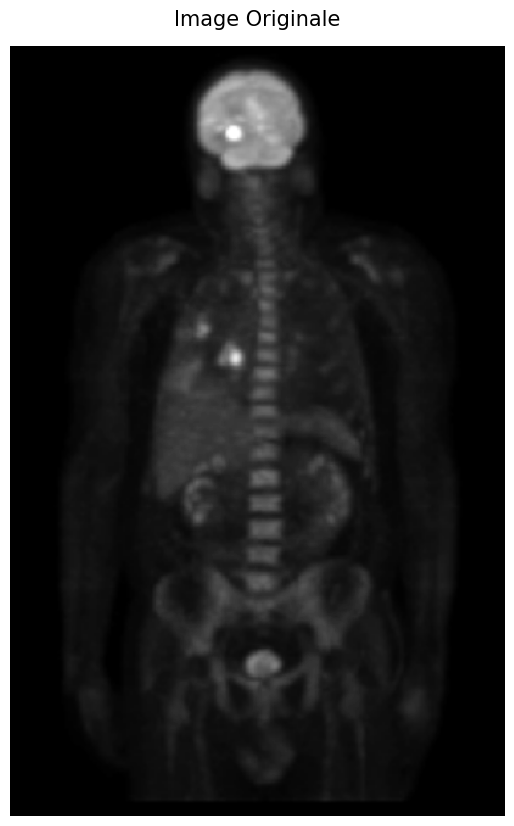

In [3]:
# Charger image
A = np.double(plt.imread('Repo/Data/PET.tif'));

out = np.zeros(A.shape, np.double)
plt.imshow(cv2.normalize(A, out, 1.0, 0.0, cv2.NORM_MINMAX), cmap='gray'); plt.title('Image Originale'); plt.axis('off'); plt.show();

In [4]:
def filtpb_gauss(A, fc, pad):
    """ Application d'un filtre gaussien sur une image im à une fréquence de coupure fc dans
        le domaine fréquentiel

    A (ndarray): Image d'entrée
    fc (float): Fréquence de coupure
    pad (int): Nombre de pixels de padding
    """
    M,N = A.shape
    M+=pad
    N+=pad

    # Image dans le domaine fréquentiel
    AA = np.fft.fftshift(np.fft.fft2(A, (M,N)))

    M0 = np.ceil((M+1) / 2)
    N0 = np.ceil((N+1) / 2)

    U, V = np.mgrid[1:M+1, 1:N+1]
    D2 = (U - M0)**2 + (V - N0)**2

    # Réponse fréquentielle du filtre gaussien
    HH = np.exp(-D2 / (2 * fc**2))

    # Application du filtre et retour au domaine spatial
    BB = np.fft.ifftshift(AA * HH)
    B = np.fft.ifft2(BB)
    B = np.real(B)
    return B[:A.shape[0],:A.shape[1]]

## Paramètres de filtrage

Le paramètre `gh`peut être vu comme le facteur d’amplification maximal des fréquences élevées tandis que le paramètre `gl` peut être vu comme le facteur d’atténuation minimal des basses fréquences. Le paramètre `fc` correspond à la fréquence de coupure du filtre passe-haut gaussien.



In [5]:
gh = 2
gl = 0.5
fc = 80

## Filtrage homomorphique

Une transformation logarithmique est d’abord effectuée à l’image originale + 1.

In [6]:
B = np.log(A+1);

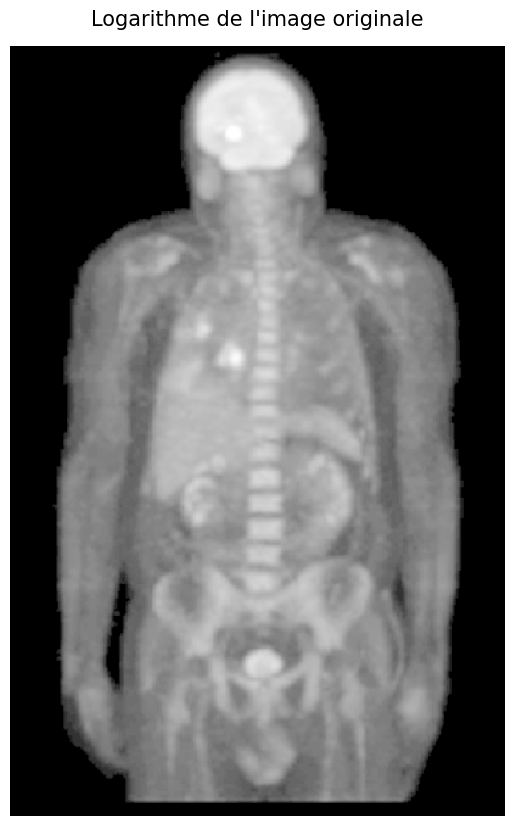

In [7]:
out = np.zeros(B.shape, np.double)
plt.imshow(cv2.normalize(B, out, 1.0, 0.0, cv2.NORM_MINMAX), cmap='gray');
plt.title("Logarithme de l'image originale");
plt.axis('off');
plt.show();

Le filtre est ensuite appliqué avec les paramètres sélectionnés.

In [8]:
C = gh * B - (gh-gl) * filtpb_gauss(B, fc,pad=0);

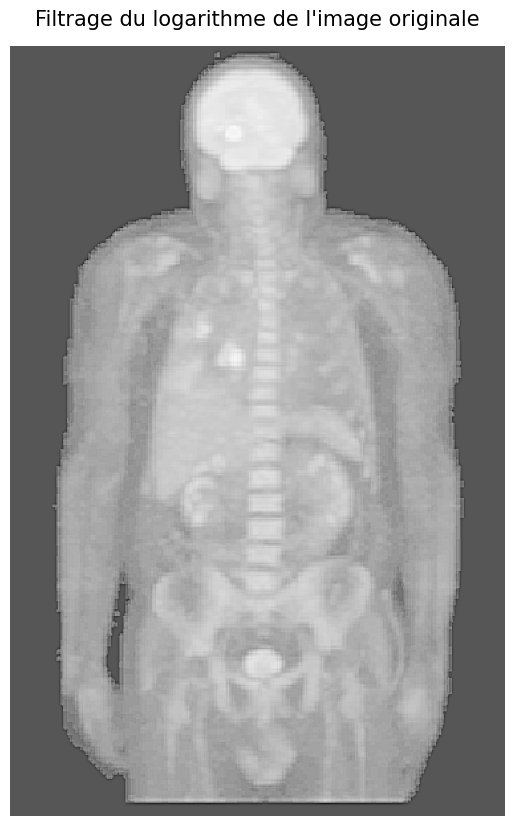

In [9]:
out = np.zeros(C.shape, np.double)
plt.imshow(cv2.normalize(C, out, 1.0, 0.0, cv2.NORM_MINMAX), cmap='gray');
plt.title("Filtrage du logarithme de l'image originale");
plt.axis('off');
plt.show();

Une transformation exponentielle est ensuite effectuée avant de soustraire 1 pour obtenir le résultat final.

In [12]:
D = np.exp(C)-1

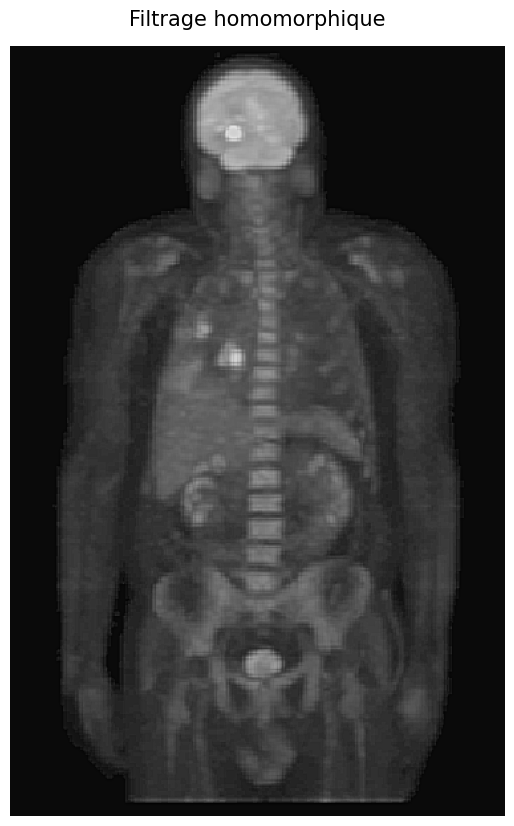

In [13]:
out = np.zeros(B.shape, np.double)
plt.imshow(cv2.normalize(D, out, 1.0, 0.0, cv2.NORM_MINMAX), cmap='gray');
plt.title("Filtrage homomorphique");
plt.axis('off');
plt.show();

## Comparaison

Beaucoup plus de détails sont visibles sur l’image obtenue par filtrage homomorphique que sur l’image originale, notamment au niveau des bras et des jambes. La transformation gamma permet également une amélioration du contraste de l’image dans les régions à faible intensité. Cependant, l’image obtenue par filtrage homomorphique est beaucoup plus affinée. Cette différence est particulièrement visible au niveau du squelette, du cerveau et des certains autres organes.

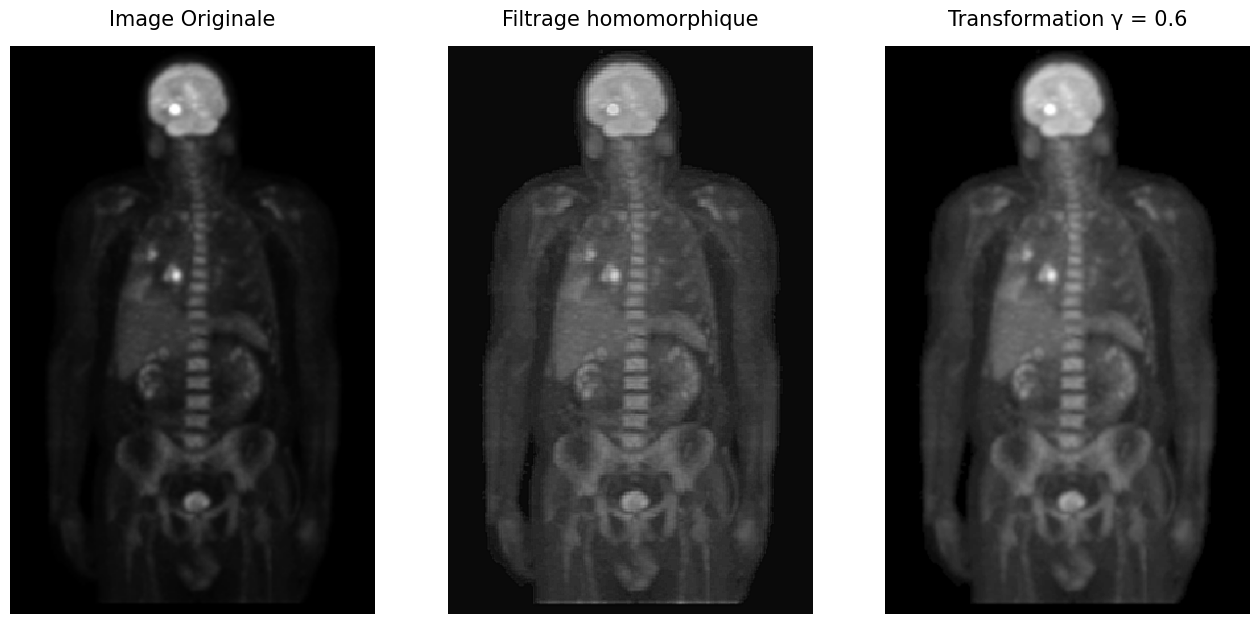

In [14]:
out = np.zeros(A.shape, np.double)
plt.subplot(131); plt.imshow(cv2.normalize(A, out, 1.0, 0.0, cv2.NORM_MINMAX), cmap='gray'); plt.title('Image Originale'); plt.axis('off');
out = np.zeros(B.shape, np.double)
plt.subplot(132); plt.imshow(cv2.normalize(D, out, 1.0, 0.0, cv2.NORM_MINMAX), cmap='gray'); plt.title("Filtrage homomorphique"); plt.axis('off');
out = np.zeros(A.shape, np.double)
plt.subplot(133); plt.imshow(cv2.normalize(A, out, 1.0, 0.0, cv2.NORM_MINMAX)**0.6, cmap='gray'); plt.title('Transformation \u03B3 = 0.6'); plt.axis('off'); plt.show();